In [38]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

In [39]:
#Clase que detendra el sobre ajuste
class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('')
        print('.', end='')
def print_history(history):  
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    # Graficación de la pérdida durante el entrenamiento y la validación
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Graficación de la precisión durante el entrenamiento y la validación
    plt.subplot(1, 2, 2)
    plt.plot(accuracy, label='Training Accuracy')
    plt.plot(val_accuracy, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## Tratamiento y exporacion de la data, en este caso se construiran 3 diferentes modelos para cual trabajaremos de 3 diferentes formas con la data
* 1 Se hara uso de one hot encoding en todas las columnas
* 2 Se le asignara un valor numerico para cada variable categorica
* 3 Se normalizara la data del punto 2

# Exploracion de la data

In [40]:
data = pd.read_csv("training-ds.csv")
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 964 entries, 0 to 963
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Tipo de Red               964 non-null    object
 1   Estudiante de Tecnología  964 non-null    object
 2   Nivel de Educación        964 non-null    object
 3   Vive en Ciudad            964 non-null    object
 4   Tipo de Instituto         964 non-null    object
 5   Edad                      964 non-null    object
 6   Dispositivo               964 non-null    object
 7   Tipo de Internet          964 non-null    object
 8   Situación Financiera      964 non-null    object
 9   Género                    964 non-null    object
 10  Duración de la Clase      964 non-null    object
 11  Nivel de Adaptación       964 non-null    object
dtypes: object(12)
memory usage: 90.5+ KB
None


Como se puede observar, al pedir la informacion de la data, nos podemos percatar que todas las columnas, son del tipo 'Object', lo cual indica que son del tipo de datos de texto

In [41]:
data.shape

(964, 12)

Aca tambien vemos algo basico como lo es la cantidad de filas y de columnas que tiene el dataset, en este caso de 964 filas y 12 columnas

In [42]:
def print_unique_values(data_frame, dtype='object'):
    for column in data_frame.columns:
        if data_frame[column].dtype == dtype:
            print(f'{column}: {list(data_frame[column].unique())}')


print_unique_values(data)

Tipo de Red: ['3G', '4G', '2G']
Estudiante de Tecnología: ['Si', 'No']
Nivel de Educación: ['Universidad', 'Escuela', 'Colegio']
Vive en Ciudad: ['Si', 'No']
Tipo de Instituto: ['Privado', 'Público']
Edad: ['21-25', 'Nov-15', '16-20', '26-30', '01-May', '06-Oct']
Dispositivo: ['Computadora', 'Smartphone', 'Tableta']
Tipo de Internet: ['Wifi', 'Compra Megas']
Situación Financiera: ['Media', 'Mala', 'Buena']
Género: ['Masculino', 'Femenino']
Duración de la Clase: ['03-Jun', '01-Mar', '0']
Nivel de Adaptación: ['Bajo', 'Moderado', 'Alto']


Aca lo que se hace es tener un avision general de los valores únicos en cada columna del conjunto de datos.

Aca lo que se pudo observar es que hay algunas fechas de edad y de duracion de la clase que tienen letras como Nov, etc.


## Columnas relevantes para los distintos casos

Buscando que columnas son relevantes  para nuestro modelo en el caso 1

In [43]:
data_transform= data
data_transform = pd.get_dummies(data, columns=[ 'Estudiante de Tecnología', "Vive en Ciudad",'Tipo de Instituto','Tipo de Internet','Género'])

Lo primero que hacemos aca es una copia del data set para luego aplicarle get_dummies, esta funcion se caracteriza por realizar one-hot de las variables categoricas. Esto significa que en este caso creara columnas adicionales para 'Estudiante de Texnologia', 'Vive en Ciudad', 'Tipo de Instituto', y  'Genero'.

In [44]:
correlation_level_adaption = data_transform.corrwith(data_transform['Nivel de Adaptación'], method='kendall')
correlation_level_adaption = correlation_level_adaption.abs().sort_values(ascending=False)
print(correlation_level_adaption.head(11))


Tipo de Instituto_Privado        0.205034
Tipo de Instituto_Público        0.205034
Vive en Ciudad_No                0.136796
Vive en Ciudad_Si                0.136796
Estudiante de Tecnología_No      0.064079
Estudiante de Tecnología_Si      0.064079
Tipo de Internet_Compra Megas    0.049212
Tipo de Internet_Wifi            0.049212
Género_Femenino                  0.024113
Género_Masculino                 0.024113
dtype: float64


C:\Users\miky1\AppData\Local\Temp\ipykernel_7440\2795010018.py:1: FutureWarning: The default value of numeric_only in DataFrame.corrwith is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_level_adaption = data_transform.corrwith(data_transform['Nivel de Adaptación'], method='kendall')


Con la funcion corrwith calculamos la correlacion de cada columna con la columna 'nivel de adaptacion', esto se logra porque aplicamos el metodo de correlacion de Kendall, lo que hace este medoto es evaluar la asociación entre dos variables clasificadas.

La funcion abs() es para tratar con la magnitud de la correlación  y tambien los ordenamos en orden descendente.

Para finalizar podemos ver como es la correlacion de cada columna con la columna de nivel de adaptacion, con esto nos damos cuenta que los unicos que parecen tener el nivel mas alto son "Duracion de la clase", "Tipo de Instituto_Privado", "Tipo de Instituto_Público", "Situación Financiera ", sin embargo apra este primer caso, utilizaremos todas las columnas aplicandoles one hot encoding.

Buscando que columnas son relevantes  para nuestro modelo en el caso 2

# Procesamiento de la data

In [45]:
def convertir_mes_a_numero(fecha):
    if len(fecha) == 5 and fecha[1] == '-' and fecha[2:].isdigit():
        return fecha  
    
    meses = {
        'Jan': '1', 'Feb': '2', 'Mar': '3', 'Apr': '4',
        'May': '5', 'Jun': '6', 'Jul': '7', 'Aug': '8',
        'Sep': '9', 'Oct': '10', 'Nov': '11', 'Dec': '12'
    }
    if len(fecha) == 6 and fecha[2] == '-' and fecha[:2].isdigit():
        numero_mes = meses.get(fecha[3:])
        if numero_mes:
            return f"{int(fecha[:2])}-{numero_mes.zfill(2)}"
    
    partes = fecha.split('-')
    numero_mes = meses.get(partes[0])
    if numero_mes:
        return f"{numero_mes}-{partes[1]}"
    else:
        return fecha 

data['Edad'] = data['Edad'].apply(convertir_mes_a_numero)
data['Duración de la Clase'] = data['Duración de la Clase'].apply(convertir_mes_a_numero)

En esta funcion nos concentramos en cambiar y arreglar los datos de las columnas "Edad" y "Duracion de la clase", convertimos los meses en datos numericos para un mejor manejo de la data y que no haya errores.

A continuacion se muestra es resultado.

In [46]:
data

,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,3G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Media,Masculino,3-06,Bajo
1,3G,No,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Femenino,1-03,Moderado
2,3G,Si,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Mala,Masculino,1-03,Bajo
3,3G,Si,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Masculino,1-03,Moderado
4,4G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Buena,Masculino,1-03,Alto
...,...,...,...,...,...,...,...,...,...,...,...,...
959,3G,No,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Media,Masculino,1-03,Moderado
960,3G,No,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Femenino,1-03,Moderado
961,4G,No,Universidad,Si,Público,21-25,Smartphone,Compra Megas,Media,Masculino,0,Bajo
962,3G,No,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Media,Masculino,1-03,Moderado


Manejo de la data tipo 1

In [47]:
#ESTO NO SE SI HAY QUE BORRARLO
data_transform= data
data_transform = pd.get_dummies(data, columns=[ 'Estudiante de Tecnología', "Vive en Ciudad",'Tipo de Instituto','Tipo de Internet','Género'])
display(data_transform.head(100))

,Tipo de Red,Nivel de Educación,Edad,Dispositivo,Situación Financiera,Duración de la Clase,Nivel de Adaptación,Estudiante de Tecnología_No,Estudiante de Tecnología_Si,Vive en Ciudad_No,Vive en Ciudad_Si,Tipo de Instituto_Privado,Tipo de Instituto_Público,Tipo de Internet_Compra Megas,Tipo de Internet_Wifi,Género_Femenino,Género_Masculino
0,3G,Universidad,21-25,Computadora,Media,3-06,Bajo,0,1,0,1,1,0,0,1,0,1
1,3G,Escuela,11-15,Smartphone,Media,1-03,Moderado,1,0,0,1,1,0,1,0,1,0
2,3G,Universidad,21-25,Smartphone,Mala,1-03,Bajo,0,1,0,1,1,0,1,0,0,1
3,3G,Escuela,11-15,Smartphone,Media,1-03,Moderado,0,1,0,1,1,0,1,0,0,1
4,4G,Universidad,21-25,Computadora,Buena,1-03,Alto,0,1,0,1,1,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,4G,Colegio,16-20,Smartphone,Media,0,Bajo,0,1,1,0,0,1,1,0,0,1
96,4G,Escuela,16-20,Computadora,Media,1-03,Bajo,1,0,0,1,1,0,0,1,1,0
97,4G,Universidad,21-25,Smartphone,Media,0,Bajo,1,0,0,1,1,0,1,0,0,1
98,3G,Universidad,21-25,Smartphone,Media,1-03,Bajo,1,0,0,1,0,1,1,0,0,1


In [48]:
mapping = {'Bajo': 0, 'Moderado': 1, 'Alto': 2}
data_transform['Nivel de Adaptación'] = data_transform['Nivel de Adaptación'].map(mapping)

print(data_transform['Nivel de Adaptación'])


0      0
1      1
2      0
3      1
4      2
      ..
959    1
960    1
961    0
962    1
963    1
Name: Nivel de Adaptación, Length: 964, dtype: int64


Para nuestro primer caso, lo que hacemos es, los datos de la columna de adaptacion, les damos valores numericos, en este caso que van desde 0 a 2, relacionados desde nivel de apatacion bajo a nivel de adaptacion alto respectivamente.

### Manejo de la data tipo 2

In [49]:
data_encoded = data.apply(LabelEncoder().fit_transform)
display(data_encoded.head(100))

,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,1,1,2,1,0,3,0,1,2,1,2,1
1,1,0,1,1,0,1,1,0,2,0,1,2
2,1,1,2,1,0,3,1,0,1,1,1,1
3,1,1,1,1,0,1,1,0,2,1,1,2
4,2,1,2,1,0,3,0,1,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,2,1,0,0,1,2,1,0,2,1,0,1
96,2,0,1,1,0,2,0,1,2,0,1,1
97,2,0,2,1,0,3,1,0,2,1,0,1
98,1,0,2,1,1,3,1,0,2,1,1,1


In [50]:
correlation_nivel_adaptacion_encod = data_encoded.corr(method='pearson')['Nivel de Adaptación']
display((correlation_nivel_adaptacion_encod[np.argsort(correlation_nivel_adaptacion_encod, axis=0)[::-1]]).head(11))

Nivel de Adaptación         1.000000
Situación Financiera        0.258934
Duración de la Clase        0.209937
Vive en Ciudad              0.104525
Dispositivo                 0.066690
Estudiante de Tecnología    0.044715
Tipo de Red                 0.021874
Nivel de Educación         -0.015269
Género                     -0.042976
Tipo de Internet           -0.069489
Tipo de Instituto          -0.172572
Name: Nivel de Adaptación, dtype: float64

### Data tipo 3

In [51]:
scaler = StandardScaler()
labels = data_encoded['Nivel de Adaptación']

# Normalizar las características excepto 'Nivel de Adaptación'
data_except_labels = data_encoded.drop('Nivel de Adaptación', axis=1)
data_except_labels_normalized = scaler.fit_transform(data_except_labels)
data_except_labels_normalized = pd.DataFrame(data_except_labels_normalized, columns=data_except_labels.columns)

# Reconstruir el dataset con las características normalizadas y la columna 'Nivel de Adaptación'
data_normalice = pd.concat([data_except_labels_normalized, labels], axis=1)

display(data_normalice.head(100))

,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase,Nivel de Adaptación
0,-1.240771,1.722521,1.103632,0.524531,-0.675421,0.735289,-2.228075,1.155050,0.558508,0.901127,1.767815,1
1,-1.240771,-0.580544,-0.278058,0.524531,-0.675421,-0.920829,0.310772,-0.865763,0.558508,-1.109721,-0.080530,2
2,-1.240771,1.722521,1.103632,0.524531,-0.675421,0.735289,0.310772,-0.865763,-1.103225,0.901127,-0.080530,1
3,-1.240771,1.722521,-0.278058,0.524531,-0.675421,-0.920829,0.310772,-0.865763,0.558508,0.901127,-0.080530,2
4,0.710458,1.722521,1.103632,0.524531,-0.675421,0.735289,-2.228075,1.155050,-2.764958,0.901127,-0.080530,0
...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.710458,1.722521,-1.659748,-1.906467,1.480558,-0.092770,0.310772,-0.865763,0.558508,0.901127,-1.928874,1
96,0.710458,-0.580544,-0.278058,0.524531,-0.675421,-0.092770,-2.228075,1.155050,0.558508,-1.109721,-0.080530,1
97,0.710458,-0.580544,1.103632,0.524531,-0.675421,0.735289,0.310772,-0.865763,0.558508,0.901127,-1.928874,1
98,-1.240771,-0.580544,1.103632,0.524531,1.480558,0.735289,0.310772,-0.865763,0.558508,0.901127,-0.080530,1


Buscando que columnas son relevantes  para nuestro modelo en el caso 3

In [52]:
correlation_nivel_adaptacion_norm = data_normalice.corr(method='pearson')['Nivel de Adaptación']
display((correlation_nivel_adaptacion_norm[np.argsort(correlation_nivel_adaptacion_norm, axis=0)[::-1]]).head(11))

Nivel de Adaptación         1.000000
Situación Financiera        0.258934
Duración de la Clase        0.209937
Vive en Ciudad              0.104525
Dispositivo                 0.066690
Estudiante de Tecnología    0.044715
Tipo de Red                 0.021874
Nivel de Educación         -0.015269
Género                     -0.042976
Tipo de Internet           -0.069489
Tipo de Instituto          -0.172572
Name: Nivel de Adaptación, dtype: float64

# Training

In [58]:
x = data.drop('Nivel de Adaptación' , axis = 1)
y = data_transform['Nivel de Adaptación']
x

,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase
0,3G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Media,Masculino,3-06
1,3G,No,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Femenino,1-03
2,3G,Si,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Mala,Masculino,1-03
3,3G,Si,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Masculino,1-03
4,4G,Si,Universidad,Si,Privado,21-25,Computadora,Wifi,Buena,Masculino,1-03
...,...,...,...,...,...,...,...,...,...,...,...
959,3G,No,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Media,Masculino,1-03
960,3G,No,Escuela,Si,Privado,11-15,Smartphone,Compra Megas,Media,Femenino,1-03
961,4G,No,Universidad,Si,Público,21-25,Smartphone,Compra Megas,Media,Masculino,0
962,3G,No,Universidad,Si,Privado,21-25,Smartphone,Compra Megas,Media,Masculino,1-03


En esta seccion, lo que hacemos es primero que nada dividir el data set en dos secciones, 'x' y 'y' en x guardaremos todas las columnas del data set, excepto la columna del nivel de adaptacion que es la que queremos comparar.

En 'y' se guardara solo la columna de nivel de adaptacion. 

In [59]:

x_train , x_test , y_train , y_test = train_test_split(pd.get_dummies(x) , y , test_size = 0.2 , random_state = 42)


Luego dividimos el data set de la siguiente manera: 
    
    - Para entrenar el data set "x_train"= lo que hacemos es on hot encoding de todas las columnas que fueron seleciconadas antes.
    - "x_test" = y, lo cual sera nuestra columna objetivo con los valores de nivel de adaptacion
    - "y_train" = "test_size = 0.2", significa que solo usaremos el 20% de los datos para prueba
    - "y_test" = "random_state = 42" Nos da una semilla para garantizar que la division sea la misma cada vez que ejecutamos el codigo

In [60]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train.shape[1:]),
    tf.keras.layers.Dense(100 , activation = 'relu'),
    tf.keras.layers.Dense(100 , activation = 'relu'),
    tf.keras.layers.Dense(100 , activation = 'relu'),
    tf.keras.layers.Dense(100 , activation = 'relu'),
    tf.keras.layers.Dense(3 , activation = 'softmax')
])

model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy , optimizer = tf.keras.optimizers.Adam() , metrics = ['accuracy'])

model.fit(x_train , y_train , epochs = 200)

Epoch 1/200
25/25 [==============================] - 1s 4ms/step - loss: 0.8564 - accuracy: 0.6252
Epoch 2/200
25/25 [==============================] - 0s 4ms/step - loss: 0.7238 - accuracy: 0.6757
Epoch 3/200
25/25 [==============================] - 0s 4ms/step - loss: 0.6597 - accuracy: 0.7185
Epoch 4/200
25/25 [==============================] - 0s 3ms/step - loss: 0.6113 - accuracy: 0.7380
Epoch 5/200
25/25 [==============================] - 0s 3ms/step - loss: 0.5515 - accuracy: 0.7730
Epoch 6/200
25/25 [==============================] - 0s 3ms/step - loss: 0.4942 - accuracy: 0.7899
Epoch 7/200
25/25 [==============================] - 0s 4ms/step - loss: 0.5019 - accuracy: 0.7847
Epoch 8/200
25/25 [==============================] - 0s 3ms/step - loss: 0.5136 - accuracy: 0.7808
Epoch 9/200
25/25 [==============================] - 0s 3ms/step - loss: 0.4142 - accuracy: 0.8314
Epoch 10/200
25/25 [==============================] - 0s 3ms/step - loss: 0.4082 - accuracy: 0.8405
Epoch 11/

In [ ]:
loss , acc = model.evaluate(x_test , y_test)
acc

7/7 [==============================] - 0s 3ms/step - loss: 0.3414 - accuracy: 0.8653


0.8652849793434143

### Construccion del modelo para el caso 2

In [ ]:

X_encod = data_encoded.drop('Nivel de Adaptación' , axis = 1)
y_encod = data_encoded['Nivel de Adaptación']
x_train_encod , x_test_encod , y_train_encod , y_test_encod = train_test_split(X_encod , y_encod , test_size = 0.2 , random_state = 42)
model_encode = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape = x_train_encod.shape[1:]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(33 , activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(66 , activation = "gelu"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2) ,
    tf.keras.layers.Dense(3 , activation = 'softmax')
])

# Compilar el modelo
model_encode.compile(loss='sparse_categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# Entrenar el modelo con callbacks
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model_encode.fit(x_train_encod, y_train_encod, epochs=100, validation_split=0.2, batch_size=64, callbacks=[early_stop, PrintDot()])


test_loss, test_accuracy = model_encode.evaluate(x_test_encod, y_test_encod)
print(f'Test accuracy: {test_accuracy}')



Epoch 1/100
10/10 [==============================] - 3s 45ms/step - loss: 1.4038 - accuracy: 0.4075 - val_loss: 1.1820 - val_accuracy: 0.2774
Epoch 2/100
10/10 [==============================] - 0s 10ms/step - loss: 1.0673 - accuracy: 0.5552 - val_loss: 1.1073 - val_accuracy: 0.4516
Epoch 3/100
10/10 [==============================] - 0s 10ms/step - loss: 0.9407 - accuracy: 0.6023 - val_loss: 1.0572 - val_accuracy: 0.4968
Epoch 4/100
10/10 [==============================] - 0s 9ms/step - loss: 0.8722 - accuracy: 0.6299 - val_loss: 1.0363 - val_accuracy: 0.4968
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 0.8072 - accuracy: 0.6591 - val_loss: 1.0182 - val_accuracy: 0.5161
Epoch 6/100
10/10 [==============================] - 0s 9ms/step - loss: 0.7452 - accuracy: 0.6753 - val_loss: 0.9932 - val_accuracy: 0.5290
Epoch 7/100
10/10 [==============================] - 0s 9ms/step - loss: 0.7599 - accuracy: 0.6705 - val_loss: 0.9650 - val_accuracy: 0.5290
Epoch 8/10

In [ ]:
loss_encod , acc_encod = model_encode.evaluate(x_test_encod , y_test_encod)
acc_encod

7/7 [==============================] - 0s 3ms/step - loss: 0.4125 - accuracy: 0.8342


0.8341968655586243

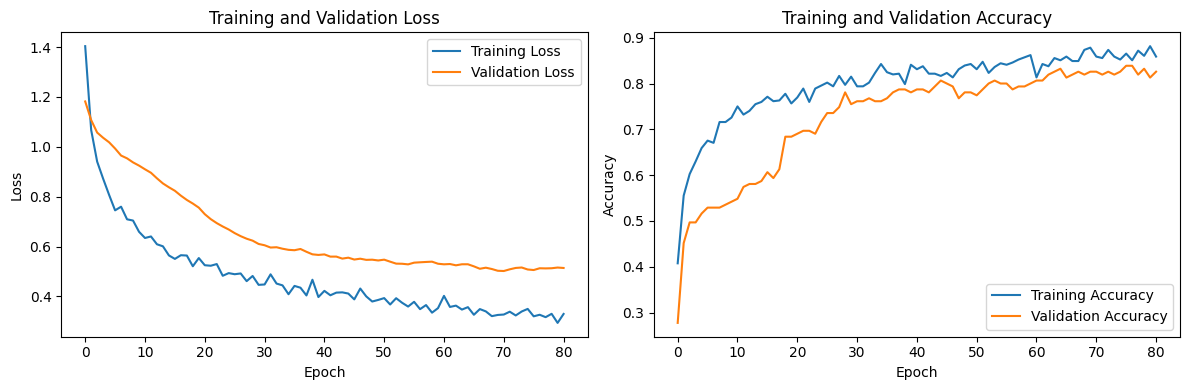

In [ ]:
print_history(history)

In [ ]:
#guardando el mejor modelo obtenido hasta ahora
#model_dir = './BestModel'
#tf.saved_model.save(model_encode, model_dir)
#model_encode.save('bestAcury86_11_25.h5')

In [ ]:
loaded_model = tf.keras.models.load_model('bestAcury86_11_25.h5')

# Ahora puedes utilizar métodos como evaluate y predict en el modelo cargado
loss_encod, acc_encod = loaded_model.evaluate(x_test_encod, y_test_encod)

7/7 [==============================] - 0s 3ms/step - loss: 0.3944 - accuracy: 0.8601


### Caso 3

In [61]:
X_norm = data_normalice.drop('Nivel de Adaptación' , axis = 1)
y_norm = data_normalice['Nivel de Adaptación']
x_train_norm , x_test_norm , y_train_norm , y_test_norm = train_test_split(X_norm , y_norm , test_size = 0.2, random_state = 32 )

model_norm = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=x_train_norm.shape[1:]),
    tf.keras.layers.Dense(33, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])

model_norm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=['accuracy']
)

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history_norm = model_norm.fit(
    x_train_norm,
    y_train_norm,
    epochs=100,
    validation_split=0.2,
    batch_size=64,
    callbacks=[callback]
)




Epoch 1/100
10/10 [==============================] - 1s 30ms/step - loss: 1.0355 - accuracy: 0.4610 - val_loss: 0.9077 - val_accuracy: 0.6323
Epoch 2/100
10/10 [==============================] - 0s 11ms/step - loss: 0.9416 - accuracy: 0.5276 - val_loss: 0.8396 - val_accuracy: 0.6645
Epoch 3/100
10/10 [==============================] - 0s 11ms/step - loss: 0.8767 - accuracy: 0.5731 - val_loss: 0.7993 - val_accuracy: 0.6581
Epoch 4/100
10/10 [==============================] - 0s 10ms/step - loss: 0.8612 - accuracy: 0.6039 - val_loss: 0.7721 - val_accuracy: 0.6516
Epoch 5/100
10/10 [==============================] - 0s 9ms/step - loss: 0.8259 - accuracy: 0.6380 - val_loss: 0.7539 - val_accuracy: 0.6516
Epoch 6/100
10/10 [==============================] - 0s 8ms/step - loss: 0.8048 - accuracy: 0.6558 - val_loss: 0.7407 - val_accuracy: 0.6581
Epoch 7/100
10/10 [==============================] - 0s 9ms/step - loss: 0.7686 - accuracy: 0.6510 - val_loss: 0.7315 - val_accuracy: 0.6645
Epoch 8/1

In [63]:
test_loss_norm, test_accuracy_norm = model_norm.evaluate(x_test_norm, y_test_norm)
print(f'Test accuracy: {test_accuracy_norm}')

7/7 [==============================] - 0s 3ms/step - loss: 0.5327 - accuracy: 0.7772
Test accuracy: 0.7772020697593689


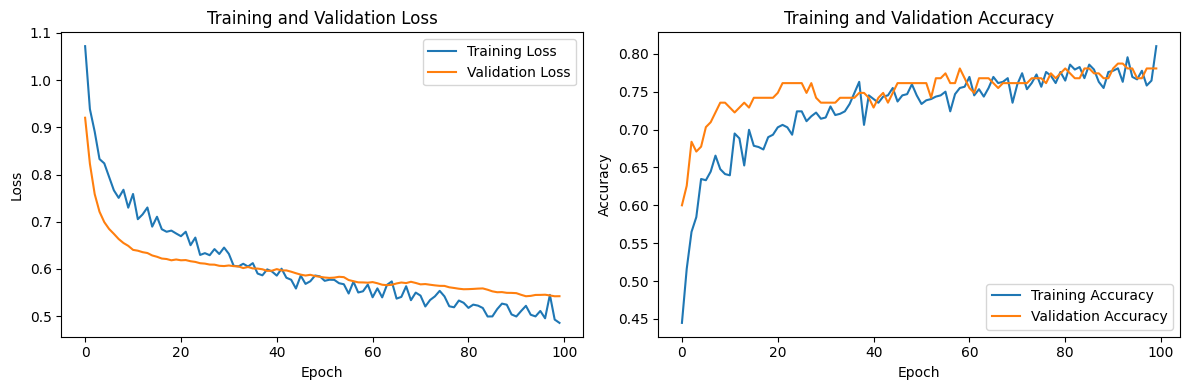

In [ ]:
print_history(history_norm)

## CArgando la data con la que realizaremos las prediciones

In [65]:
data_test = pd.read_csv("submission-ds.csv")
data_test
data_test['Edad'] = data_test['Edad'].apply(convertir_mes_a_numero)
data_test['Duración de la Clase'] = data_test['Duración de la Clase'].apply(convertir_mes_a_numero)

data_test1 =pd.get_dummies(data_test)
print_unique_values(data_test)


Tipo de Red: ['3G', '4G', '2G']
Estudiante de Tecnología: ['No', 'Si']
Nivel de Educación: ['Colegio', 'Universidad', 'Escuela']
Vive en Ciudad: ['No', 'Si']
Tipo de Instituto: ['Público', 'Privado']
Edad: ['21-25', '16-20', '6-Oct', '15-11', '1-May', '26-30']
Dispositivo: ['Smartphone', 'Computadora', 'Tableta']
Tipo de Internet: ['Compra Megas', 'Wifi']
Situación Financiera: ['Mala', 'Media', 'Buena']
Género: ['Masculino', 'Femenino']
Duración de la Clase: ['1-Mar', '0', '3-Jun']


In [66]:

data_test = data_test.apply(LabelEncoder().fit_transform)
data_test
data_test3 = data_test
scaler = StandardScaler()
normalized_array = scaler.fit_transform(data_test3)
data_test3 = pd.DataFrame(normalized_array, columns=data_test3.columns)
data_test3


,Tipo de Red,Estudiante de Tecnología,Nivel de Educación,Vive en Ciudad,Tipo de Instituto,Edad,Dispositivo,Tipo de Internet,Situación Financiera,Género,Duración de la Clase
0,-1.132569,-0.582142,-1.647325,-1.699146,1.418626,0.684911,0.172958,-0.820738,-1.028259,0.916349,-0.107984
1,0.776166,-0.582142,-1.647325,-1.699146,-0.704907,-0.136301,0.172958,1.218415,0.591417,-1.091288,-0.107984
2,0.776166,-0.582142,1.148487,0.588531,1.418626,0.684911,0.172958,-0.820738,0.591417,0.916349,-1.842919
3,-1.132569,1.717795,1.148487,-1.699146,1.418626,0.684911,0.172958,-0.820738,0.591417,0.916349,-0.107984
4,-1.132569,-0.582142,-0.249419,-1.699146,1.418626,2.327333,0.172958,-0.820738,0.591417,-1.091288,-1.842919
...,...,...,...,...,...,...,...,...,...,...,...
236,0.776166,-0.582142,-0.249419,0.588531,-0.704907,-1.778723,0.172958,1.218415,0.591417,-1.091288,-0.107984
237,0.776166,-0.582142,-0.249419,0.588531,-0.704907,-1.778723,0.172958,-0.820738,0.591417,-1.091288,-0.107984
238,0.776166,-0.582142,-0.249419,0.588531,-0.704907,-0.957512,0.172958,-0.820738,0.591417,0.916349,-0.107984
239,0.776166,-0.582142,-0.249419,0.588531,1.418626,-0.136301,0.172958,1.218415,0.591417,0.916349,-0.107984


### Preciendo caso 1

In [67]:
pedict_m1= model.predict(data_test1)
predict_model1 = pedict_m1.argmax(axis=1)
print(predict_model1)

8/8 [==============================] - 0s 3ms/step
[0 0 0 0 0 1 0 1 0 0 0 1 1 0 0 1 0 1 1 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0
 1 1 0 1 0 0 0 1 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 0 0 1 0 1 0 1
 0 1 1 0 1 1 1 1 0 1 1 2 1 0 1 1 1 1 1 1 1 2 1 1 1 0 1 2 0 1 1 0 0 1 1 1 1
 0 1 0 0 1 1 1 1 0 1 0 2 0 1 0 1 0 2 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 1 1
 2 1 1 0 1 1 1 1 1 1 1 1 0 2 1 1 0 2 2 1 0 1 1 1 1 0 0 1 0 0 1 0 2 0 1 0 0
 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 1 1 1 0
 0 0 1 1 1 0 1 1 1 0 2 1 0 0 1 1 1 1 1]


In [68]:
resultados_prediccion1 = pd.DataFrame({
    'id': range(1, len(predict_model1) + 1),
    'Nivel de Adaptación': predict_model1
})
resultados_prediccion1['Nivel de Adaptación'] = resultados_prediccion1['Nivel de Adaptación'].map({0: 'Bajo', 1: 'Moderado', 2: 'Alto'})

print(resultados_prediccion1)
resultados_prediccion1.to_csv('resultados_prediccion_m1_2.csv', index=False)

      id Nivel de Adaptación
0      1                Bajo
1      2                Bajo
2      3                Bajo
3      4                Bajo
4      5                Bajo
..   ...                 ...
236  237            Moderado
237  238            Moderado
238  239            Moderado
239  240            Moderado
240  241            Moderado

[241 rows x 2 columns]


### Predicion Caso 2

In [ ]:
predictions = loaded_model.predict(data_test)
predicted_classes = predictions.argmax(axis=1)
print(predicted_classes)

8/8 [==============================] - 0s 2ms/step
[2 1 1 1 1 0 1 2 1 1 1 2 2 1 1 2 2 2 2 2 1 1 2 2 2 1 1 1 1 2 2 1 0 2 1 1 1
 2 2 1 2 1 1 1 2 2 2 2 1 2 2 1 2 1 2 2 1 2 2 1 2 1 1 2 1 2 1 1 1 2 1 2 1 2
 1 2 2 1 2 2 2 2 1 2 2 0 1 1 2 2 2 2 2 2 2 2 2 2 2 1 2 0 1 2 2 1 1 2 2 2 2
 1 2 1 1 2 2 2 0 1 2 1 2 1 2 1 2 1 0 1 2 1 2 2 2 2 1 1 1 2 2 2 2 1 2 2 2 1
 0 2 2 1 2 2 2 2 2 2 2 2 1 0 0 2 1 2 0 2 1 2 2 2 2 1 1 2 1 1 2 1 2 1 2 1 1
 2 1 2 2 2 2 2 1 2 2 1 1 1 1 2 1 1 2 2 2 2 2 1 2 2 1 1 2 2 1 2 2 1 1 1 2 1
 1 1 2 2 2 1 2 2 2 1 0 2 1 1 2 2 2 2 2]


In [ ]:
resultados_prediccion = pd.DataFrame({
    'id': range(1, len(predicted_classes) + 1),
    'Nivel de Adaptación': predicted_classes
})
resultados_prediccion['Nivel de Adaptación'] = resultados_prediccion['Nivel de Adaptación'].map({0: 'Alto', 1: 'Bajo', 2: 'Moderado'})

# Mostrar el DataFrame con las etiquetas mapeadas
print(resultados_prediccion)


      id Nivel de Adaptación
0      1            Moderado
1      2                Bajo
2      3                Bajo
3      4                Bajo
4      5                Bajo
..   ...                 ...
236  237            Moderado
237  238            Moderado
238  239            Moderado
239  240            Moderado
240  241            Moderado

[241 rows x 2 columns]


In [ ]:
resultados_prediccion.to_csv('resultados_prediccion_ac86.csv', index=False)

### predic model 3

In [ ]:
predictions3 = model_norm.predict(data_test3)
predicted_classes3 = predictions3.argmax(axis=1)
print(predicted_classes3)

8/8 [==============================] - 0s 3ms/step
[0 0 0 1 0 2 0 1 0 0 0 1 1 0 0 1 0 1 1 2 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0
 2 1 0 1 0 0 0 0 1 1 1 0 1 1 0 1 0 1 1 0 1 1 0 1 0 0 1 0 1 0 1 0 1 0 1 0 1
 0 1 1 0 1 1 1 0 0 1 1 2 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 1 1
 0 0 0 0 1 1 1 2 0 1 0 1 0 1 0 1 0 2 0 1 0 1 1 1 1 0 0 0 1 1 1 1 0 1 1 0 1
 2 1 2 0 1 1 1 1 1 1 1 1 0 2 2 1 0 1 2 1 0 1 1 1 1 0 0 1 0 0 1 0 1 0 1 1 0
 1 0 1 0 1 1 1 0 1 1 0 0 0 0 2 0 0 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0 0 0 1 0
 0 0 1 1 1 0 1 1 1 0 2 1 2 0 1 1 1 1 1]


In [ ]:
resultados_prediccion3 = pd.DataFrame({
    'id': range(1, len(predicted_classes3) + 1),
    'Nivel de Adaptación': predicted_classes3
})
resultados_prediccion3['Nivel de Adaptación'] = resultados_prediccion3['Nivel de Adaptación'].map({0: 'Alto', 1: 'Bajo', 2: 'Moderado'})

# Mostrar el DataFrame con las etiquetas mapeadas
print(resultados_prediccion3)


      id Nivel de Adaptación
0      1                Alto
1      2                Alto
2      3                Alto
3      4                Bajo
4      5                Alto
..   ...                 ...
236  237                Bajo
237  238                Bajo
238  239                Bajo
239  240                Bajo
240  241                Bajo

[241 rows x 2 columns]


In [ ]:
resultados_prediccion3.to_csv('resultados_prediccion_norm.csv', index=False)



## Guardando los conjuntos de datos para realizar experimentos en otro notebook

In [70]:
data_encoded.to_csv('Data_train_categoric_as_num.csv', index=False)

In [72]:
data_normalice.to_csv('Data_train_normalize.csv', index=False)

In [74]:
new_data = pd.concat([x, y], axis=1)

# Guardar el nuevo DataFrame en un archivo CSV
new_data.to_csv('data_m1.csv', index=False)